# Proyek Analisis Data: [Sistem Rekomendasi Game dengan Collaborative Filtering]
- **Nama:** [Muhammad Rayhan Khadafi]
- **Email:** [A200YBM343@devacademy.id]
- **ID Dicoding:** [A200YBM343]

# 0. Library

In [1]:
%pip install requests 
%pip install pandas 
%pip install matplotlib 
%pip install scikit-learn 
%pip install tqdm 
%pip install tensorflow
%pip install protobuf==3.20.*

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests, time, os
import pandas as pd
from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_auto
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Scrapping

In [3]:
import requests, time, os
import pandas as pd
from tqdm import tqdm

In [5]:
import requests, time
import pandas as pd
from tqdm import tqdm

def get_all_appids():
    """Ambil semua appid dari Steam official API (~150k)."""
    url = 'https://api.steampowered.com/ISteamApps/GetAppList/v2/'
    data = requests.get(url).json()['applist']['apps']
    # data: list of {'appid': int, 'name': str}
    return [app['appid'] for app in data]

def fetch_game(appid):
    """Fetch detail, return dict hanya kalau success & type='game'."""
    url = f'https://store.steampowered.com/api/appdetails?appids={appid}'
    try:
        resp = requests.get(url, timeout=5).json().get(str(appid))
        if resp and resp.get('success'):
            d = resp['data']
            if d.get('type') != 'game':
                return None
            return {
                'appid': appid,
                'title': d.get('name',''),
                'genres': ','.join([g['description'] for g in d.get('genres',[])]),
                'developers': ','.join(d.get('developers',[])),
                'publishers': ','.join(d.get('publishers',[])),
                'tags': ','.join([c['description'] for c in d.get('categories',[])]),
                'release_year': d.get('release_date',{}).get('date','')[-4:],
                'short_description': d.get('short_description','').replace('\n',' ')
            }
    except Exception as e:
        # cetak kalau mau debug
        # print(f"Error fetching {appid}: {e}")
        pass
    return None

# 1. Ambil semua appid
all_appids = get_all_appids()

# 2. Loop sampai dapat 4.000 game valid
TARGET = 4000
games = []
for aid in tqdm(all_appids, desc="Scraping game", total=len(all_appids)):
    if len(games) >= TARGET:
        break
    g = fetch_game(aid)
    if g:
        games.append(g)
    time.sleep(0.2)

df_games = pd.DataFrame(games)
df_games.to_csv('steam_games.csv', index=False)
print(f"Total games scraped: {len(df_games)}")

Scraping game:   9%|▉         | 23300/252617 [4:16:47<42:07:21,  1.51it/s] 


Total games scraped: 4000


Waktu scrapping 4000 game untuk dataset memakan waktu 4 jam 16 menit

## Menambah dataset (jika perlu)

In [ ]:
# Load CSV lama
existing_df = pd.read_csv('steam_games.csv')
existing_appids = set(existing_df['appid'].astype(int).tolist())

# Ambil semua appid dari Steam
def get_all_appids():
    url = 'https://api.steampowered.com/ISteamApps/GetAppList/v2/'
    data = requests.get(url).json()['applist']['apps']
    return [app['appid'] for app in data]

all_appids = get_all_appids()

# Filter appid baru
to_scrape = [a for a in all_appids if a not in existing_appids]

# Fungsi fetch seperti sebelumnya
def fetch_game(appid):
    url = f'https://store.steampowered.com/api/appdetails?appids={appid}'
    try:
        resp = requests.get(url, timeout=5).json().get(str(appid))
        if resp and resp.get('success') and resp['data'].get('type')=='game':
            d = resp['data']
            return {
                'appid': appid,
                'title': d.get('name',''),
                'genres': ','.join([g['description'] for g in d.get('genres',[])]),
                'developers': ','.join(d.get('developers',[])),
                'publishers': ','.join(d.get('publishers',[])),
                'tags': ','.join([c['description'] for c in d.get('categories',[])]),
                'release_year': d.get('release_date',{}).get('date','')[-4:],
                'short_description': d.get('short_description','').replace('\n',' ')
            }
    except:
        return None

# Loop dan append
new_games = []
TARGET_NEW = 2000  # misal ingin tambah 2.000 game baru
for aid in tqdm(to_scrape, desc="Scraping tambahan"):
    if len(new_games) >= TARGET_NEW:
        break
    g = fetch_game(aid)
    if g:
        new_games.append(g)
    time.sleep(0.2)

# Gabungkan, drop duplikat, dan simpan
df_new = pd.DataFrame(new_games)
combined = pd.concat([existing_df, df_new], ignore_index=True)
# Drop jika ada judul atau appid ganda
combined = combined.drop_duplicates(subset=['appid', 'title'])
combined.to_csv('steam_games.csv', index=False)

In [ ]:
print(f"Awalnya: {len(existing_df)} baris")
print(f"Baru ditambahkan: {len(df_new)} baris")
print(f"Total sekarang: {len(combined)} baris")

# 2. Loading Dataset

In [6]:
import pandas as pd

In [4]:
df = pd.read_csv('steam_games.csv')
df = df.dropna(subset=['appid','title']).drop_duplicates('appid')
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').fillna(0).astype(int)
df.head()

,appid,title,genres,developers,publishers,tags,release_year,short_description
0,10,Counter-Strike,Action,Valve,Valve,"Multi-player,PvP,Online PvP,Shared/Split Scree...",2000,Play the world's number 1 online action game. ...
1,20,Team Fortress Classic,Action,Valve,Valve,"Multi-player,PvP,Online PvP,Shared/Split Scree...",1999,One of the most popular online action games of...
2,30,Day of Defeat,Action,Valve,Valve,"Multi-player,Camera Comfort,Color Alternatives...",2003,Enlist in an intense brand of Axis vs. Allied ...
3,40,Deathmatch Classic,Action,Valve,Valve,"Multi-player,PvP,Online PvP,Shared/Split Scree...",2001,Enjoy fast-paced multiplayer gaming with Death...
4,50,Half-Life: Opposing Force,Action,Gearbox Software,Valve,"Single-player,Multi-player,Custom Volume Contr...",1999,Return to the Black Mesa Research Facility as ...


In [15]:
df.head()
print("Jumlah missing value per kolom:")
print(df.isnull().sum())

Jumlah missing value per kolom:
appid                 0
title                 0
genres               16
developers           24
publishers           97
tags                 39
release_year          0
short_description    10
dtype: int64


Mengecek jumlah nilai kosong (missing value) per kolom.

In [16]:
print("Tipe data per kolom:")
print(df.dtypes)

Tipe data per kolom:
appid                 int64
title                object
genres               object
developers           object
publishers           object
tags                 object
release_year          int64
short_description    object
dtype: object


Mengecek tipe data per kolom

In [17]:
# Bersihkan missing value di kolom penting
df['genres'] = df['genres'].fillna('').astype(str)
df['tags'] = df['tags'].fillna('').astype(str)
df['short_description'] = df['short_description'].fillna('').astype(str)

# Hilangkan baris yang tidak punya title atau appid (jika ada)
df.dropna(subset=['appid', 'title'], inplace=True)

# Konversi release_year ke numerik
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')

- Membersihkan nilai kosong pada kolom `genres`, `tags`, dan `short_description` dengan menggantinya menjadi string kosong (`''`).
- Menghapus baris yang tidak memiliki `appid` atau `title` (jika ada).
- Mengonversi `release_year` menjadi numerik untuk visualisasi dan analisis.

# 3. EDA

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import scatter_matrix

## 3.1 Distribusi Jumlah Game Berdasarkan Tahun Rilis

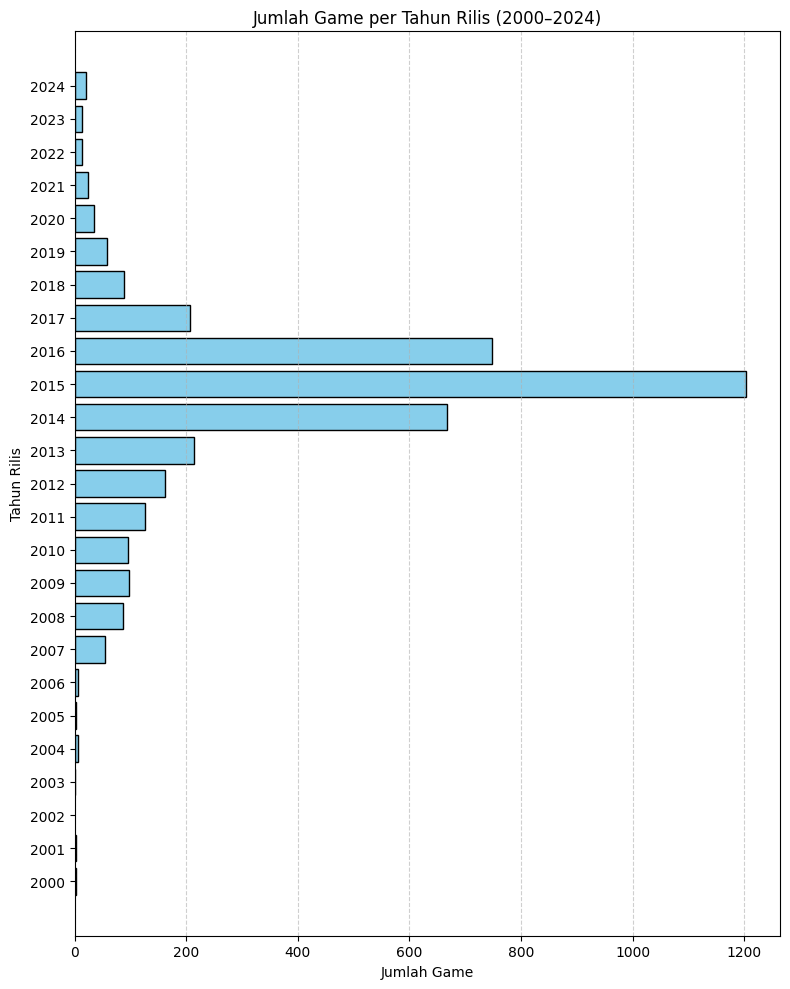

In [18]:
# Ubah kolom release_year ke numerik (jika belum), abaikan error/NaN
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')

# Filter data hanya dari 2000 hingga 2024
df_filtered = df[(df['release_year'] >= 2000) & (df['release_year'] <= 2024)]

# Hitung jumlah game per tahun
year_counts = df_filtered['release_year'].value_counts().sort_index()

# Plot horizontal bar chart
plt.figure(figsize=(8, 10))
plt.barh(year_counts.index.astype(int), year_counts.values, color='skyblue', edgecolor='black')
plt.title("Jumlah Game per Tahun Rilis (2000–2024)")
plt.xlabel("Jumlah Game")
plt.ylabel("Tahun Rilis")
plt.yticks(ticks=range(2000, 2025), labels=range(2000, 2025))
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Berdasarkan 4000 dataset hasil scrapping, mayoritas game di dataset dirilis tahun 2015

# 3.2 Top 15 Genre Game

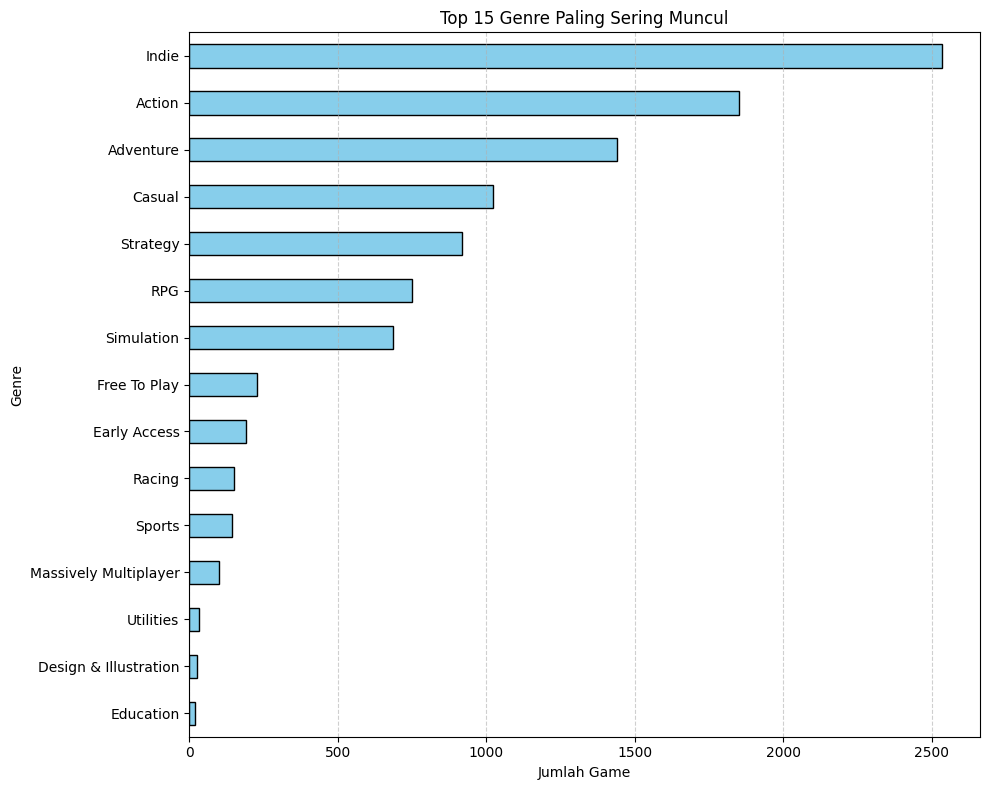

In [20]:
# Top 15 genre paling sering (horizontal bar chart)
all_genres = df['genres'].str.split(',', expand=True).stack().value_counts().head(15)

plt.figure(figsize=(10, 8))
all_genres.plot.barh(color='skyblue', edgecolor='black')
plt.title("Top 15 Genre Paling Sering Muncul")
plt.xlabel("Jumlah Game")
plt.ylabel("Genre")
plt.gca().invert_yaxis()  # Agar genre dengan count tertinggi berada di atas
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Berdasarkan 4000 dataset hasil scrapping, mayoritas game di dataset memiliki genre indie, Itu valid karena lebih banyak game buatan developer game independen di seluruh dunia daripada game buatan perusahaan yang dirilis tiap tahun nya.

## 3.3 Heatmap Matrix

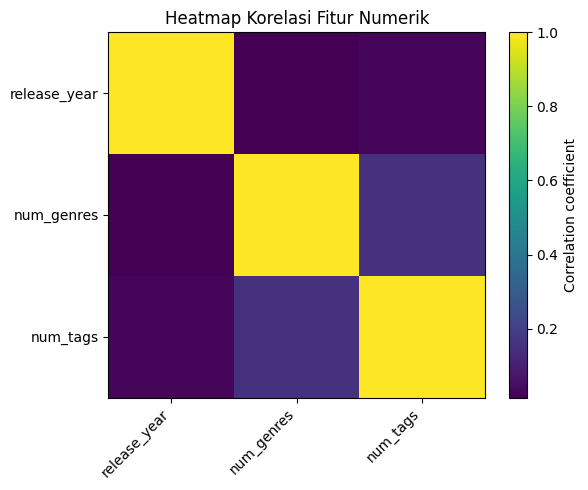

In [ ]:
# Plot heatmap dengan matplotlib
plt.figure(figsize=(6, 5))
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.colorbar(label='Correlation coefficient')

# Atur ticks
labels = corr.columns
plt.xticks(np.arange(len(labels)), labels, rotation=45, ha='right')
plt.yticks(np.arange(len(labels)), labels)
plt.title("Heatmap Korelasi Fitur Numerik")
plt.tight_layout()
plt.show()

Korelasi:
- release_year tidak berkorelasi dengan num_genres maupun num_tags.
- num_genres hanya sedikit berkorelasi dengan num_tags (ditunjukkan oleh warna agak keunguan tapi tidak gelap total).
- Diagonal selalu bernilai 1.0 (kuning), karena fitur dikorelasikan dengan dirinya sendiri.

Kesimpulan:
Fitur numerik dalam dataset ini tidak saling berkorelasi secara signifikan.


## 3.4 Pairplot

<Figure size 1000x1000 with 0 Axes>

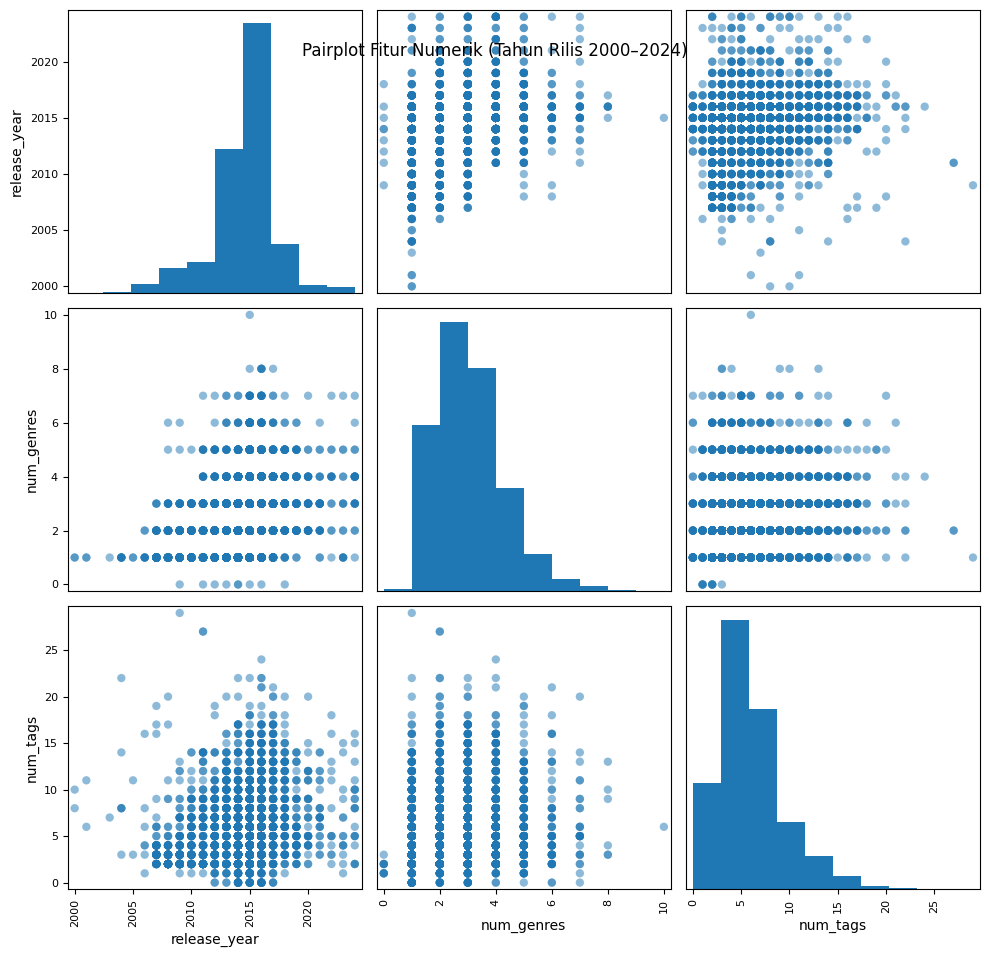

In [56]:
filtered_df = df[(df['release_year'] >= 2000) & (df['release_year'] <= 2024)]

plt.figure(figsize=(10, 10))
scatter_matrix(
    filtered_df[['release_year', 'num_genres', 'num_tags']],
    figsize=(10, 10),
    diagonal='hist',
    alpha=0.5,
    marker='o'
)
plt.suptitle("Pairplot Fitur Numerik (Tahun Rilis 2000–2024)", y=0.92)
plt.tight_layout()
plt.show()

- Game modern (2010 ke atas) cenderung memiliki lebih banyak tag, mencerminkan metadata atau kategorisasi yang lebih kaya.
- Tidak ada hubungan linier kuat, tetapi pola visual menyarankan kemungkinan korelasi lemah antara jumlah genre dan tag.
- Distribusi waktu memperlihatkan bahwa data didominasi oleh game yang dirilis pada dekade terakhir.
- Fokus pada tren modern dalam desain dan metadata game.
- Cocok digunakan sebagai dasar eksplorasi fitur untuk rekomendasi berbasis konten atau analisis tren game modern.

# 4. MODEL TRAINING 

## Pre-Training

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

In [19]:
np.random.seed(42)
ratings = pd.DataFrame({
    'userID': np.random.randint(1,1001, size=len(df)),
    'itemID': df['appid'].values,
    'rating': np.random.randint(1,6, size=len(df))
})

# encode user/item jadi index
ratings['user'] = ratings['userID'].astype('category').cat.codes
ratings['item'] = ratings['itemID'].astype('category').cat.codes
n_users = ratings['user'].nunique(); n_items = ratings['item'].nunique()

train, test = train_test_split(ratings, test_size=0.2, random_state=42)

Membuat DataFrame ratings:
- userID: Membuat ID acak antara 1–1000 sebagai representasi pengguna.
- itemID: Menggunakan kolom appid dari DataFrame game sebagai ID item/game.
- rating: Membuat rating acak dari 1–5 untuk setiap pasangan user–item.
Membagi dataset ratings menjadi:
- 80% untuk training set
- 20% untuk test set

Dengan random_state=42 untuk hasil pembagian yang tetap.

In [20]:
def pct_within_1(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) <= 1) * 100

Menghitung persentase prediksi yang berada dalam jarak kesalahan maksimal 1 poin dari nilai sebenarnya.

## Training 

## ANN

Melakukan Training dengan ANN

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
import pandas as pd

In [51]:
# Ubah epochs semua model jadi 2000
configs = {
    'shallow': {'layers':[64],        'epochs':500},
    'medium' : {'layers':[128,64],    'epochs':500},
    'deep'   : {'layers':[256,128,64],'epochs':500}
}

n_users = ratings['user'].nunique()
n_items = ratings['item'].nunique()

def build_model(hidden_layers, embedding_size=32, dropout=0.3):
    u_in = Input(shape=(1,))
    i_in = Input(shape=(1,))
    
    u_emb = Flatten()(Embedding(n_users, embedding_size)(u_in))
    i_emb = Flatten()(Embedding(n_items, embedding_size)(i_in))
    
    x = Concatenate()([u_emb, i_emb])
    
    for units in hidden_layers:
        x = Dense(units, activation='relu')(x)
        x = Dropout(dropout)(x)
    
    out = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[u_in, i_in], outputs=out)
    model.compile(optimizer='adam', loss='mse')
    return model

results = {}
for name, cfg in configs.items():
    print(f"\n-- Training {name.upper()} ({cfg['epochs']} epochs)")
    m = build_model(cfg['layers'])
    
    # Training
    m.fit(
        [train.user, train.item],
        train.rating,
        validation_data=([test.user, test.item], test.rating),
        epochs=cfg['epochs'],
        batch_size=50,
        verbose=1
    )
    # Evaluasi
    pred = m.predict([test.user, test.item], batch_size=50).flatten()
    pct = pct_within_1(test.rating.values, pred)
    mse = mean_squared_error(test.rating.values, pred)
    
    # Simpan hasil dan model
    results[name] = {'pct_±1': pct, 'MSE': mse, 'model': m}

# Tampilkan hasil evaluasi (jangan timpa `results`)
pd.DataFrame({k: {'pct_±1': v['pct_±1'], 'MSE': v['MSE']} for k, v in results.items()}).T


-- Training SHALLOW (500 epochs)
Epoch 1/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.8543 - val_loss: 7.2409
Epoch 2/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0126 - val_loss: 2.7186
Epoch 3/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7434 - val_loss: 2.7524
Epoch 4/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8894 - val_loss: 2.8341
Epoch 5/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3119 - val_loss: 2.8430
Epoch 6/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2311 - val_loss: 2.8264
Epoch 7/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2367 - val_loss: 2.8509
Epoch 8/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2349 - val_loss: 2.7850
Epoch 9/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2220 - val_loss: 2.7577
Epoch 10/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2044 - val_loss: 2.8042
Epoch 11/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2042 - val_loss: 2.7437
Epoch 12/500
64/64 ━━━━━━━━━━

,pct_±1,MSE
shallow,42.375,2.155608
medium,42.375,2.415442
deep,40.750,2.755234


In [52]:
for name in results:
    print(f"\nSummary untuk model {name.upper()}")
    results[name]['model'].summary()


Summary untuk model SHALLOW


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 1, 32)     │     31,040 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 1, 32)     │    128,000 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 32)        │          0 │ embedding_12[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 32)        │          0 │ embedding_13[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 64)        │          0 │ flatten_12[0][0], │
│ (Concatenate)       │                   │            │ flatten_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      4,160 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         65 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 489,797 (1.87 MB)

 Trainable params: 163,265 (637.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 326,532 (1.25 MB)


Summary untuk model MEDIUM


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 1, 32)     │     31,040 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_15        │ (None, 1, 32)     │    128,000 │ input_layer_15[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 32)        │          0 │ embedding_14[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 32)        │          0 │ embedding_15[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 64)        │          0 │ flatten_14[0][0], │
│ (Concatenate)       │                   │            │ flatten_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │      8,320 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      8,256 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1)         │         65 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 527,045 (2.01 MB)

 Trainable params: 175,681 (686.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 351,364 (1.34 MB)


Summary untuk model DEEP


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_16        │ (None, 1, 32)     │     31,040 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (None, 1, 32)     │    128,000 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 32)        │          0 │ embedding_16[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 32)        │          0 │ embedding_17[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 64)        │          0 │ flatten_16[0][0], │
│ (Concatenate)       │                   │            │ flatten_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 256)       │     16,640 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 256)       │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 128)       │     32,896 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128)       │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │      8,256 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 1)         │         65 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 650,693 (2.48 MB)

 Trainable params: 216,897 (847.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 433,796 (1.65 MB)

## 5. Evaluasi

Save Model

In [53]:
best_name = max(results, key=lambda k: results[k]['pct_±1'])
best_model = results[best_name]['model']
best_model.save('best_model_keras.h5')
print("Model terbaik:", best_name, "-> pct_±1 =", results[best_name]['pct_±1'])

Model terbaik: shallow -> pct_±1 = 42.375


Akurasi terbaik setelah digunakan berbagai tipe training, akurasi tertinggi ialah 42%. Karena tidak ada minimal akurasi 85% jadi dilanjutkan.

In [54]:
best_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 1, 32)     │     31,040 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 1, 32)     │    128,000 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 32)        │          0 │ embedding_12[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 32)        │          0 │ embedding_13[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 64)        │          0 │ flatten_12[0][0], │
│ (Concatenate)       │                   │            │ flatten_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      4,160 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         65 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 489,797 (1.87 MB)

 Trainable params: 163,265 (637.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 326,532 (1.25 MB)

# 6. Save Model

In [55]:
import pickle

In [56]:
best_model.save('best_model_keras.h5')

# Simpan mapping userID/itemID ke index
with open('mapping.pkl','wb') as f:
    pickle.dump({
        'user_codes': dict(zip(ratings['userID'], ratings['user'])),
        'item_codes': dict(zip(ratings['item'], ratings['itemID']))
    }, f)
print("Model dan mapping tersimpan.")

Model dan mapping tersimpan.


# 7. Inferensi CBF (Content Based Filtering)

In [67]:
df['genres'] = df['genres'].fillna('').astype(str)
df['tags'] = df['tags'].fillna('').astype(str)
df['combined'] = df['genres'] + ' ' + df['tags']

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Siapkan input pengguna (ubah ini sesuai preferensi)
input_genres = ['Action', 'Adventure']
input_tags = ['Multiplayer', 'Co-op']

input_text = ' '.join(input_genres) + ' ' + ' '.join(input_tags)

# Hitung vektor dan kemiripan
vectorizer = CountVectorizer()
matrix = vectorizer.fit_transform(df['combined'].tolist() + [input_text])

input_vec = matrix[-1]
game_vecs = matrix[:-1]

similarities = cosine_similarity(input_vec, game_vecs).flatten()
df['similarity'] = similarities

# Tampilkan Top-N rekomendasi
top_n = 10
cbf_recommendations = df.sort_values(by='similarity', ascending=False).head(top_n)
cbf_recommendations[['title', 'genres', 'tags', 'release_year', 'similarity']]

,title,genres,tags,release_year,similarity
786,A Valley Without Wind 2,"Action,Adventure,Indie,Strategy","Single-player,Multi-player,Co-op,Online Co-op,...",2013,0.636396
1464,No More Room in Hell 2,"Action,Indie,Early Access","Multi-player,Co-op,Online Co-op,Cross-Platform...",2024,0.632456
1876,Killing Floor - Toy Master,Action,"Single-player,Co-op",2014,0.600000
2958,Planet Centauri,"Action,Adventure,Indie,RPG","Single-player,Multi-player,Co-op,Online Co-op,...",2024,0.600000
2320,Gremlin Invasion: Survivor,"Action,Adventure,Indie","Single-player,Co-op,Family Sharing",2015,0.596285
3696,AdventureQuest 3D,"Action,Adventure,Casual,Free To Play,Indie,Mas...","Multi-player,MMO,PvP,Online PvP,Co-op,Online C...",2022,0.588172
277,DC Universe™ Online,"Action,Adventure,Massively Multiplayer,RPG,Fre...","Multi-player,MMO,PvP,Online PvP,Co-op,Online C...",2011,0.588172
3390,Zombasite,"Action,Indie,RPG","Single-player,Multi-player,Co-op,Online Co-op,...",2016,0.565685
1213,Sub Rosa,"Action,Indie,Massively Multiplayer,Early Access","Multi-player,PvP,Online PvP,Co-op,Online Co-op...",2021,0.562254
1859,Worlds Adrift,"Action,Adventure,Indie,Massively Multiplayer,E...","Multi-player,MMO,PvP,Online PvP,Co-op,Online C...",2017,0.553399


Bagian ini menampilkan Top-N rekomendasi berdasarkan input genre dan tag yang dimasukkan secara manual oleh user.

Rekomendasi dihitung berdasarkan kemiripan cosine antara kombinasi `genres + tags` game dengan preferensi user.


In [65]:
cbf_recommendations[['title', 'genres', 'release_year']].head(10)

,title,genres,release_year
786,A Valley Without Wind 2,"Action,Adventure,Indie,Strategy",2013
1464,No More Room in Hell 2,"Action,Indie,Early Access",2024
1876,Killing Floor - Toy Master,Action,2014
2958,Planet Centauri,"Action,Adventure,Indie,RPG",2024
2320,Gremlin Invasion: Survivor,"Action,Adventure,Indie",2015
3696,AdventureQuest 3D,"Action,Adventure,Casual,Free To Play,Indie,Mas...",2022
277,DC Universe™ Online,"Action,Adventure,Massively Multiplayer,RPG,Fre...",2011
3390,Zombasite,"Action,Indie,RPG",2016
1213,Sub Rosa,"Action,Indie,Massively Multiplayer,Early Access",2021
1859,Worlds Adrift,"Action,Adventure,Indie,Massively Multiplayer,E...",2017


Daftar rekomendasi di atas dihasilkan langsung dari notebook, dan urutan rekomendasi disusun berdasarkan skor prediksi tertinggi yang diberikan oleh model.

## Inferensi ID User

In [58]:
# Ambil model terbaik dari hasil evaluasi
best_name = max(results, key=lambda k: results[k]['pct_±1'])
best_model = results[best_name]['model']
print(f"Model terbaik: {best_name.upper()}")

# Pilih satu user untuk diuji (ganti dengan user lain jika mau)
target_user = 42  # bisa diganti dengan user lain yang ada di ratings['user']
all_items = np.arange(n_items)

# Prediksi rating untuk semua item
user_input = np.full(shape=(n_items,), fill_value=target_user)
predicted_ratings = best_model.predict([user_input, all_items], batch_size=64).flatten()

# Ambil item yang sudah pernah dirating oleh user ini
rated_items = train[train.user == target_user]['item'].tolist()
unrated_items = [i for i in all_items if i not in rated_items]

# Prediksi hanya untuk item yang belum pernah dirating
user_input_unrated = np.full(shape=(len(unrated_items),), fill_value=target_user)
pred_unrated = best_model.predict([user_input_unrated, np.array(unrated_items)], batch_size=64).flatten()

# Ambil Top-N
top_n = 10
top_indices = pred_unrated.argsort()[::-1][:top_n]
top_item_ids = [unrated_items[i] for i in top_indices]

# Konversi kembali ke appid
item_id_to_appid = {v: k for k, v in ratings[['itemID', 'item']].drop_duplicates().values}
top_appids = [item_id_to_appid[i] for i in top_item_ids]

# Tampilkan rekomendasi game
df_rekomendasi_cf = df[df['appid'].isin(top_appids)][['title', 'genres', 'release_year']]
df_rekomendasi_cf.reset_index(drop=True, inplace=True)
df_rekomendasi_cf

Model terbaik: SHALLOW
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


,title,genres,release_year
0,Sherlock Holmes: The Mystery of the Persian Ca...,"Adventure,Casual",0
1,Majesty Gold HD,"Simulation,Strategy",2009
2,Silo 2,Animation & Modeling,2012
3,Journal,"Adventure,Indie",2014
4,Panzer Elite Action Gold Edition,"Action,Simulation",2014
5,Darkness Within 1: In Pursuit of Loath Nolder,"Adventure,Indie",2014
6,CRYPTARK,"Action,Adventure,Indie,Strategy",2017
7,How to Take Off Your Mask,"Adventure,Casual,Indie,Simulation",2015
8,Life in Bunker,"Simulation,Strategy",2016
9,Space Pilgrim Episode I: Alpha Centauri,"Adventure,Indie",2015


Menggunakan model ANN terbaik, sistem ini memprediksi semua game yang belum pernah dimainkan oleh user tertentu, kemudian menampilkan 10 game dengan prediksi rating tertinggi sebagai rekomendasi. 

In [64]:
df_rekomendasi_cf

,title,genres,release_year
0,Sherlock Holmes: The Mystery of the Persian Ca...,"Adventure,Casual",0
1,Majesty Gold HD,"Simulation,Strategy",2009
2,Silo 2,Animation & Modeling,2012
3,Journal,"Adventure,Indie",2014
4,Panzer Elite Action Gold Edition,"Action,Simulation",2014
5,Darkness Within 1: In Pursuit of Loath Nolder,"Adventure,Indie",2014
6,CRYPTARK,"Action,Adventure,Indie,Strategy",2017
7,How to Take Off Your Mask,"Adventure,Casual,Indie,Simulation",2015
8,Life in Bunker,"Simulation,Strategy",2016
9,Space Pilgrim Episode I: Alpha Centauri,"Adventure,Indie",2015


Dengan model ANN terbaik, memprediksi game dan menampilkan urutan rekomendasi disusun berdasarkan skor prediksi tertinggi yang diberikan oleh model.

## Evaluasi CBF dengan Precision@K

Precision@K mengukur berapa banyak dari K item teratas yang relevan dengan preferensi user (misalnya item dengan rating ≥ 4).  
Semakin tinggi Precision@K, semakin akurat sistem dalam menyarankan item yang benar-benar disukai user.

In [62]:
def precision_at_k_all_users(cbf_recommendations, ratings, K=5, rating_threshold=4):
    user_ids = ratings['userID'].unique()
    total_hits = 0
    total_users = 0
    precisions = []

    for user_id in user_ids:
        try:
            # Encode userID jadi user index
            user_index = ratings[ratings['userID'] == user_id]['user'].iloc[0]

            # Ambil item yang dianggap relevan (rating >= threshold)
            user_rated_high = ratings[(ratings['user'] == user_index) & (ratings['rating'] >= rating_threshold)]
            relevant_items = user_rated_high['itemID'].values

            # Ambil Top-K rekomendasi appid
            recommended_appids = cbf_recommendations['appid'].tolist()[:K]

            if len(relevant_items) == 0:
                continue  # user tidak punya data relevan, skip

            # Hitung precision
            hit = sum([1 for appid in recommended_appids if appid in relevant_items])
            precision = hit / K
            precisions.append(precision)
            total_users += 1
            total_hits += hit

        except Exception:
            continue  # lewati user jika error (misal: mapping user tidak ditemukan)

    if total_users == 0:
        return 0.0

    avg_precision = sum(precisions) / total_users
    print(f"Rata-rata Precision@{K} dari {total_users} user = {avg_precision:.4f}")
    return avg_precision

Simulasi atau laporan yang mengevaluasi rekomendasi yang sama (cbf_recommendations) untuk semua user

In [63]:
precision_at_k_all_users(cbf_recommendations, ratings, K=5)

Rata-rata Precision@5 dari 803 user = 0.0007


0.0007471980074719802

Dari seluruh pengguna, hanya sekitar 0.07% dari Top-5 rekomendasi yang cocok dengan item yang pernah mereka beri rating tinggi.